In [1]:
import numpy as np  # Importing the numpy library for numerical operations
import pandas as pd  # Importing pandas for data manipulation and analysis


In [2]:
import matplotlib.pyplot as plt  # To plot graphs and visualize data

# Splitting datasets into training and testing sets
from sklearn.model_selection import train_test_split

# For image data augmentation and preprocessing
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# To create a sequential model in Keras
from tensorflow.keras.models import Sequential

# Importing layers to build a convolutional neural network
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
# Setting up data augmentation parameters for training images
train_datagen = ImageDataGenerator(
    rescale=1./255,  # Normalizing the image pixel values
    rotation_range=20,  # Randomly rotate images in the range (degrees, 0 to 180)
    width_shift_range=0.2,  # Randomly translate images horizontally
    height_shift_range=0.2,  # Randomly translate images vertically
    shear_range=0.2,  # Applying shear transformations
    zoom_range=0.2,  # Randomly zooming inside images
    horizontal_flip=True,  # Randomly flipping half of the images horizontally
    fill_mode='nearest')  # Strategy used for filling in newly created pixels

# Creating a training data generator
train_generator = train_datagen.flow_from_directory(
    '/kaggle/input/20-skin-diseases-dataset/Dataset/train',  # Directory path for training data
    target_size=(128, 128),  # Resizing images to 128x128 for model input
    batch_size=32,  # Number of images to be yielded from the generator per batch
    class_mode='categorical')  # Type of label arrays to be returned

# Data generator for test set, with only rescaling
test_datagen = ImageDataGenerator(rescale=1./255)  # Normalizing test images

# Creating a test data generator
test_generator = test_datagen.flow_from_directory(
    '/kaggle/input/20-skin-diseases-dataset/Dataset/test',  # Directory path for testing data
    target_size=(128, 128),  # Ensuring test images are the same size as training images
    batch_size=32,  # Consistent batch size with the training data
    class_mode='categorical')  # Labels returned in the same format as training data


Found 2609 images belonging to 19 classes.
Found 897 images belonging to 20 classes.


In [4]:
path='/kaggle/input/20-skin-diseases-dataset/Dataset/train/'

In [5]:
import os
class_names = sorted(os.listdir(path))
num_classes = len(class_names)

img_size = (192, 192, 3)

print('classes: ', class_names)

classes:  ['Acne and Rosacea Photos', 'Actinic Keratosis Basal Cell Carcinoma and other Malignant Lesions', 'Atopic Dermatitis Photos', 'Cellulitis Impetigo and other Bacterial Infections', 'Eczema Photos', 'Exanthems and Drug Eruptions', 'Herpes HPV and other STDs Photos', 'Light Diseases and Disorders of Pigmentation', 'Lupus and other Connective Tissue diseases', 'Melanoma Skin Cancer Nevi and Moles', 'Poison Ivy Photos and other Contact Dermatitis', 'Psoriasis pictures Lichen Planus and related diseases', 'Seborrheic Keratoses and other Benign Tumors', 'Systemic Disease', 'Tinea Ringworm Candidiasis and other Fungal Infections', 'Urticaria Hives', 'Vascular Tumors', 'Vasculitis Photos', 'Warts Molluscum and other Viral Infections']


In [6]:
import cv2

labels = []
images = []

print('images:\n')
for cl in class_names:
    print(cl, end=' -> ')
    for img in os.listdir(path + cl):
        label = np.zeros(num_classes)
        label[class_names.index(cl)] = 1
        labels.append(label)

        image = np.asarray(cv2.resize(cv2.imread(path + cl + '/' + img, cv2.IMREAD_COLOR), img_size[0:2])[:, :, ::-1])#That line remove Blue

        #image = np.asarray(cv2.resize(cv2.imread(data_path + cl + '/' + img, cv2.COLOR_BGR2RGB), img_size[0:2]))
        images.append(image)
    print('done')


labels = np.asarray(labels)
images = np.asarray(images)

print(f'\n\nlabels shape: {labels.shape}')
print(f'images shape: {images.shape}')

images:

Acne and Rosacea Photos -> done
Actinic Keratosis Basal Cell Carcinoma and other Malignant Lesions -> done
Atopic Dermatitis Photos -> done
Cellulitis Impetigo and other Bacterial Infections -> done
Eczema Photos -> done
Exanthems and Drug Eruptions -> done
Herpes HPV and other STDs Photos -> done
Light Diseases and Disorders of Pigmentation -> done
Lupus and other Connective Tissue diseases -> done
Melanoma Skin Cancer Nevi and Moles -> done
Poison Ivy Photos and other Contact Dermatitis -> done
Psoriasis pictures Lichen Planus and related diseases -> done
Seborrheic Keratoses and other Benign Tumors -> done
Systemic Disease -> done
Tinea Ringworm Candidiasis and other Fungal Infections -> done
Urticaria Hives -> done
Vascular Tumors -> done
Vasculitis Photos -> done
Warts Molluscum and other Viral Infections -> done


labels shape: (2609, 19)
images shape: (2609, 192, 192, 3)


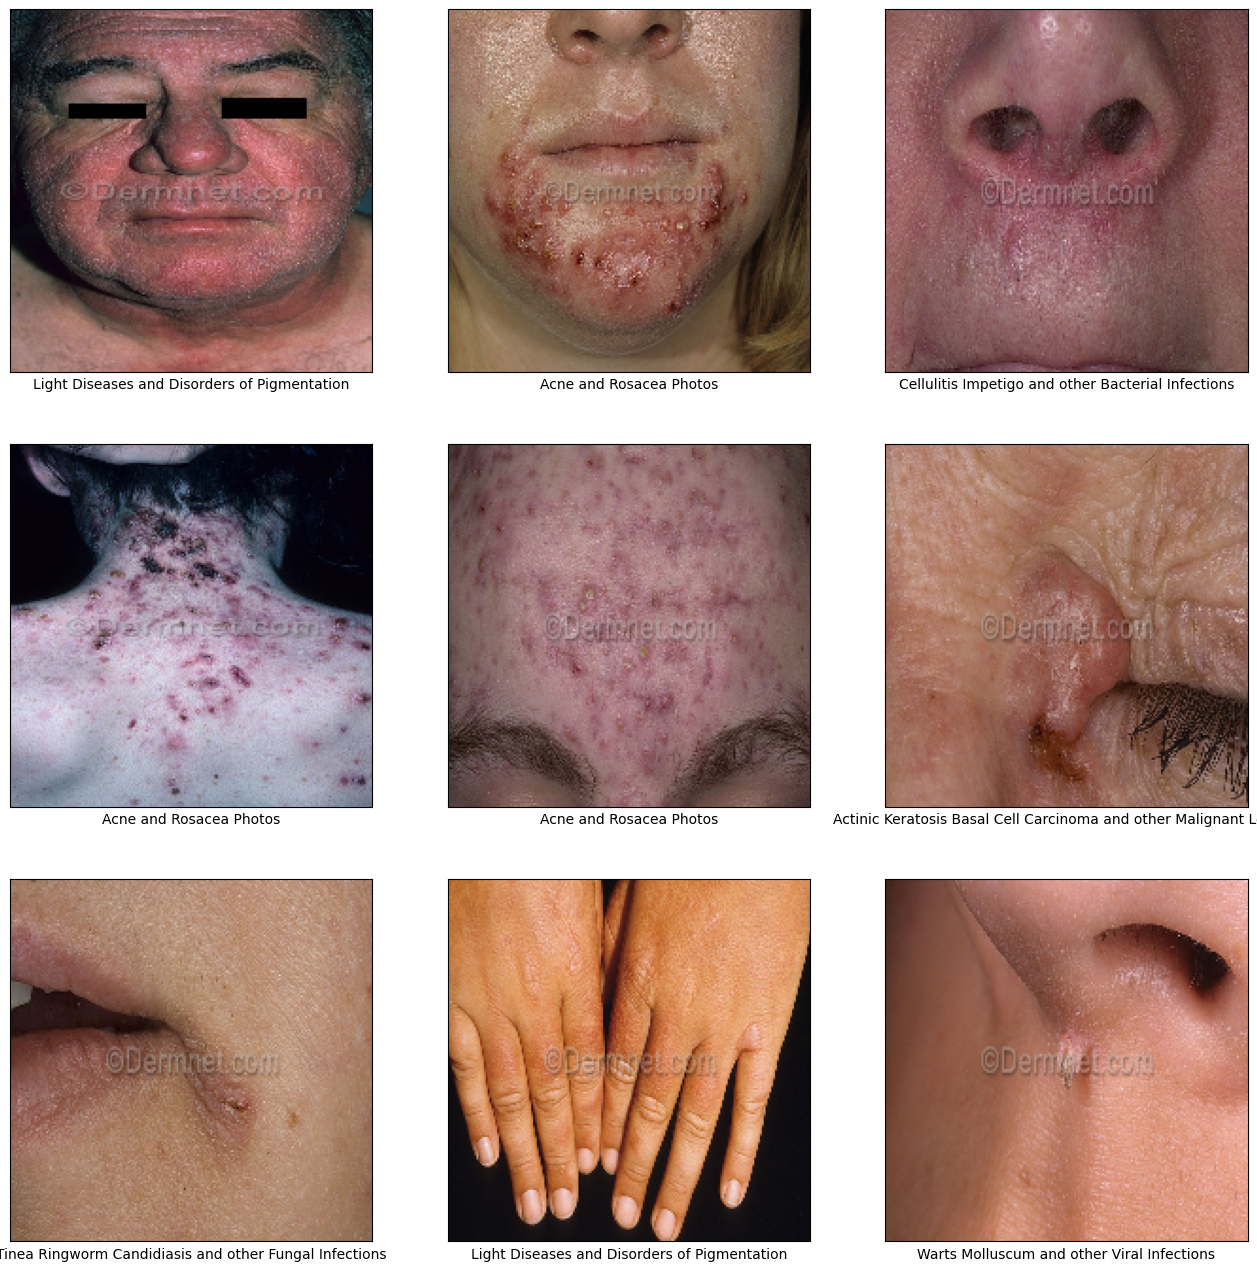

In [7]:
from random import randint

fig, axs = plt.subplots(3, 3, figsize=(16, 16))#Original was 10,6

for x in range(3):
    for y in range(3):
        i = randint(0, len(images))

        axs[x][y].imshow(images[i])


        axs[x][y].set_xticks([])
        axs[x][y].set_yticks([])
        axs[x][y].set_xlabel(class_names[np.argmax(labels[i])])


plt.show()

In [8]:

X_train, X_val, y_train, y_val = train_test_split(images, labels, test_size=0.15, random_state=42)

print(f'train images shape: {X_train.shape}\ntrain labels shape: {y_train.shape}\n\nvalidation images shape: {X_val.shape}\nvalidation labels shape: {y_val.shape}\n')

train images shape: (2217, 192, 192, 3)
train labels shape: (2217, 19)

validation images shape: (392, 192, 192, 3)
validation labels shape: (392, 19)



In [9]:
import tensorflow as tf  # Importing the TensorFlow library

# Initializing a Sequential model in Keras
cnn_model = tf.keras.Sequential()

# Adding a rescaling layer to normalize image data
cnn_model.add(tf.keras.layers.Rescaling(scale=1. / 255, input_shape=(img_size)))

# First convolutional block with two Conv2D layers and MaxPooling
cnn_model.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'))  # 1st convolutional layer with 64 filters
cnn_model.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'))  # 2nd convolutional layer, same dimensions
cnn_model.add(tf.keras.layers.MaxPooling2D(pool_size=2))  # Pooling to reduce spatial dimensions

# Second convolutional block
cnn_model.add(tf.keras.layers.Conv2D(128, (2, 2), activation='relu', padding='same'))  # Increasing filter size to 128
cnn_model.add(tf.keras.layers.Conv2D(128, (2, 2), activation='relu', padding='same'))
cnn_model.add(tf.keras.layers.MaxPooling2D(pool_size=2))

# Third convolutional block
cnn_model.add(tf.keras.layers.Conv2D(256, (2, 2), activation='relu', padding='same'))  # Further increasing filter size to 256
cnn_model.add(tf.keras.layers.Conv2D(256, (2, 2), activation='relu', padding='same'))
cnn_model.add(tf.keras.layers.MaxPooling2D(pool_size=2))

# Fourth convolutional block
cnn_model.add(tf.keras.layers.Conv2D(512, (2, 2), activation='relu', padding='same'))  # Further increasing filter size to 512
cnn_model.add(tf.keras.layers.Conv2D(512, (2, 2), activation='relu', padding='same'))
cnn_model.add(tf.keras.layers.MaxPooling2D(pool_size=2))
cnn_model.add(tf.keras.layers.Flatten())  # Flattening the output to feed into dense layers

# Dense block with three Dense layers
cnn_model.add(tf.keras.layers.Dense(256, activation='relu'))  # Dense layer with 256 neurons
cnn_model.add(tf.keras.layers.Dense(128, activation='relu'))  # Dense layer with 128 neurons
cnn_model.add(tf.keras.layers.Dense(64, activation='relu'))  # Dense layer with 64 neurons
cnn_model.add(tf.keras.layers.Dense(num_classes, activation='softmax'))  # Output layer with softmax activation

# Compiling the model with Adamax optimizer and categorical crossentropy loss
cnn_model.compile(optimizer='Adamax', loss='categorical_crossentropy', metrics=['accuracy'])

# Displaying the model's architecture
cnn_model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 192, 192, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 192, 192, 64)      1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 192, 192, 64)      36928     
                                                                 
 max_pooling2d (MaxPooling2  (None, 96, 96, 64)        0         
 D)                                                              
                                                                 
 conv2d_2 (Conv2D)           (None, 96, 96, 128)       32896     
                                                                 
 conv2d_3 (Conv2D)           (None, 96, 96, 128)       65664     
                                                        

In [10]:

from tensorflow.keras.callbacks import ModelCheckpoint

# creating ModelChecpoint callback
checkpoint_callback = ModelCheckpoint('cnn_model/model{epoch:02d}')

In [11]:
history = cnn_model.fit(images, labels, epochs=30, validation_data=(X_val, y_val), callbacks=[checkpoint_callback])

Epoch 1/30
82/82 [==============================] - 44s 322ms/step - loss: 2.3815 - accuracy: 0.3013 - val_loss: 2.3614 - val_accuracy: 0.3265
Epoch 2/30
82/82 [==============================] - 22s 266ms/step - loss: 2.3309 - accuracy: 0.3212 - val_loss: 2.3202 - val_accuracy: 0.3342
Epoch 3/30
82/82 [==============================] - 22s 268ms/step - loss: 2.2969 - accuracy: 0.3269 - val_loss: 2.3066 - val_accuracy: 0.3367
Epoch 4/30
82/82 [==============================] - 22s 271ms/step - loss: 2.2464 - accuracy: 0.3304 - val_loss: 2.2086 - val_accuracy: 0.3724
Epoch 5/30
82/82 [==============================] - 23s 277ms/step - loss: 2.2045 - accuracy: 0.3534 - val_loss: 2.2196 - val_accuracy: 0.3342
Epoch 6/30
82/82 [==============================] - 23s 275ms/step - loss: 2.1573 - accuracy: 0.3557 - val_loss: 2.1202 - val_accuracy: 0.3852
Epoch 7/30
82/82 [==============================] - 23s 278ms/step - loss: 2.0799 - accuracy: 0.3818 - val_loss: 2.0352 - val_accuracy: 0.3903

In [16]:
with open('/kaggle/working/trainHistoryDict', 'wb') as file_pi:
    pickle.dump(history.history, file_pi)

In [12]:
cnn_model.save('/kaggle/working/Model')

In [13]:
loaded_model = tf.keras.models.load_model('/kaggle/working/Model')

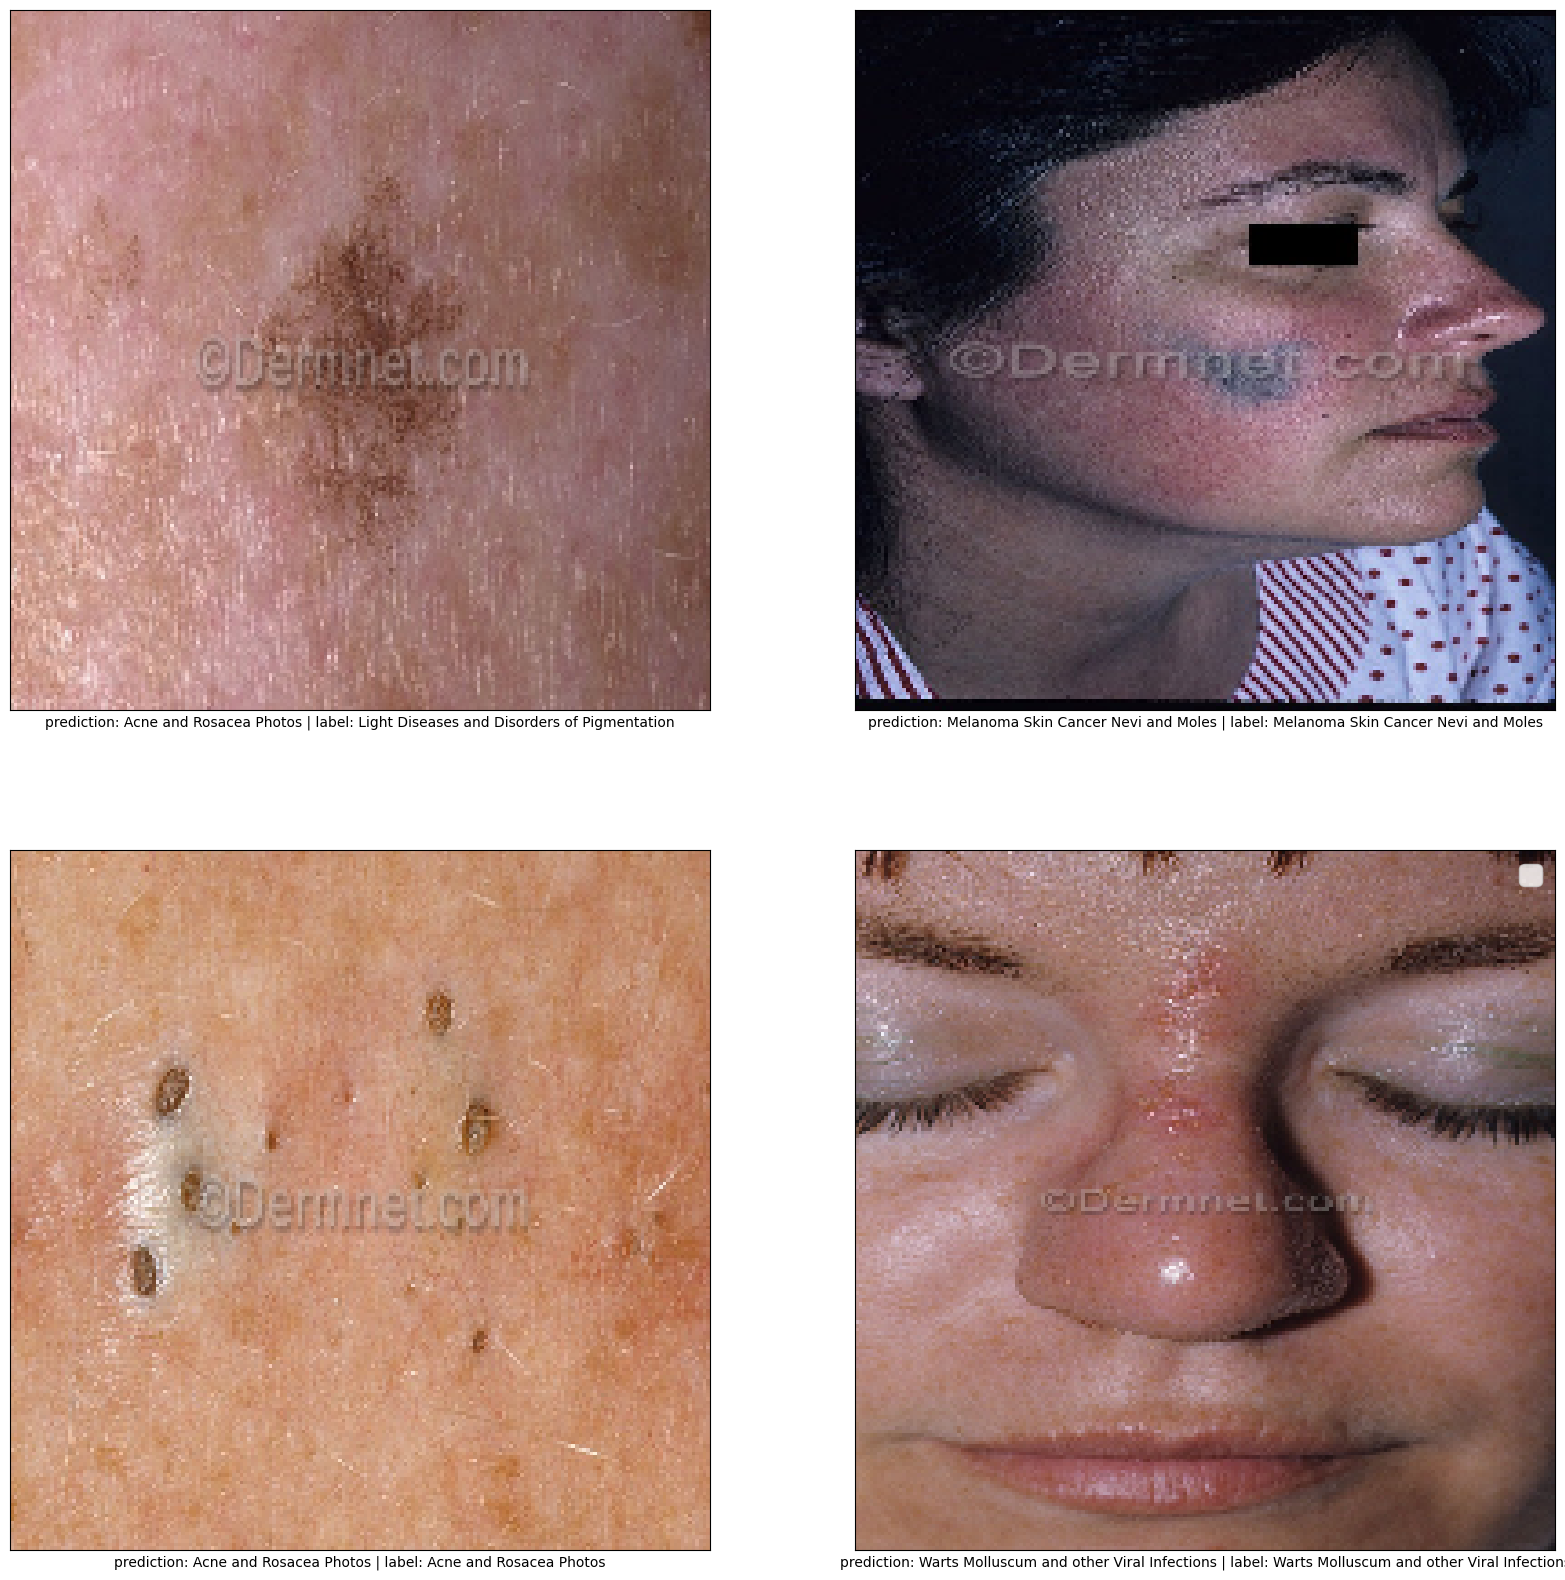

In [14]:
fig, axs = plt.subplots(2, 2, figsize=(20, 20))#Original was 7,4 (28 is higher than 25) and figsize 15,15
plt.legend(fontsize="20")#I can't read any of them

i = 0
for x in range(2): #Original was 7 so resulted in error 7X4 = 28
    for y in range(2):
        prediction = loaded_model.predict(X_val[i][None, ...], verbose=0)[0],


        axs[x][y].set_xticks([])
        axs[x][y].set_yticks([])
        axs[x][y].set_xlabel(f'prediction: {class_names[np.argmax(prediction)]} | label: {class_names[np.argmax(y_val[i])]}')

        axs[x][y].imshow(X_val[i])

        i += 1
plt.show()


In [15]:
import pickle
from keras.models import load_model

cnn_model.save('your_model.h5')



/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
